In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [66]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

from collections import Counter
import pickle

### specify directory where differential gene data is stored

In [50]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

### set parameters for plotting

In [51]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

### *Function* for randomly shuffling columns within each row

In [52]:
def randomly_subset_rows(array, p):
    '''
    This function takes in a 2D-array and randomly subsets the rows to proportion p of the original number of rows.
    '''
    #number of rows (genes) in logFC matrix
    num_rows = np.shape(array)[0] 
    
    #number of rows to randomly select (95% of original rows)
    num_rows_to_subset = int(np.ceil(p*num_rows))
    
    #row indices selected randomly without replacement
    subset_row_indices = np.random.choice(num_rows, num_rows_to_subset, replace=False)
    
    #subset original array to propotion p rows
    array_subset = array[subset_row_indices, :]
    
    return array_subset

In [53]:
def shuffle_columns_within_each_row(array):
    '''
    This function takes in a 2D-array and shuffles the columns of the array seperately for each row.
    '''
    #get number of rows & columns for input array
    nrows, ncols = array.shape

    #get the row indices for each element (will keep the same)
    rows = np.indices((nrows, ncols))[0]

    #permute the column indices for each row
    cols = [np.random.permutation(ncols) for _ in range(nrows)]

    #re-arrange elements in each row according to the chosen column indices for that row
    shuffled_array = array[rows, cols]

    return shuffled_array

### *Function* for constructing *actual* distribution of edge weights from pooled (significant) logFC changes across datasets

In [54]:
def edge_weight_distribution_from_pooled_logFC(logFC_table_filename):

    # read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
    diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
    diff_gene_exp_df.rename_axis('gene' , inplace = True)

    # Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
    # +1 if logFC > 0
    #  0 if logFC = 0
    # -1 if logFC < 0

    # store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
    direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

    # replace values in logFC matrix
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

    # convert to lower memory int8 datatype
    direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

    # compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
    # multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
    network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

    # the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
    network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))
    
    #number of rows / columns
    num_genes = np.shape(network_edge_weight_matrix)[0]

    # retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
    edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]
    
    #convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
    edge_weight_distr_counter_dict = Counter(list(edge_weight_array))
    
    return edge_weight_distr_counter_dict

### *Function* for constructing *null* distribution of edge weights from pooled (significant) logFC changes across datasets

In [55]:
def edge_weight_null_distribution_from_pooled_logFC(logFC_table_filename, N):
    
    # read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
    diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
    diff_gene_exp_df.rename_axis('gene' , inplace = True)

    # Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
    # +1 if logFC > 0
    # 0 if logFC = 0
    # -1 if logFC < 0

    # store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
    direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

    # replace values in logFC matrix
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
    direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

    # convert to lower memory int8 datatype
    direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

    # construct null distribution of shuffling the columns within each row, extracting edge weights, then adding to bucket of edge weights from many iterations
    edge_weight_null_distr_counter_dict = Counter([]) #initialize empty Counter dict

    # (shuffle columns within each row > get edge weights) x N > add to bucket of edge weights (null distribution)
    for iter_i in range(1, N+1):
        
        #randomly subset the rows to 90% of the original number of rows
        direc_diff_gene_exp_matrix_subset = randomly_subset_rows(direc_diff_gene_exp_matrix, 0.90)

        # permute the columns within each row once
        direc_diff_gene_exp_matrix_shuffled = shuffle_columns_within_each_row(direc_diff_gene_exp_matrix_subset)

        # compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
        # multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
        network_edge_weight_matrix = direc_diff_gene_exp_matrix_shuffled.dot(direc_diff_gene_exp_matrix_shuffled.T)

        # the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
        network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))
        
        #number of rows / columns
        num_genes = np.shape(network_edge_weight_matrix)[0]
        
        # retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
        edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]
        
        #convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
        edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

        # append to counter with distribution of edge weights
        edge_weight_null_distr_counter_dict = edge_weight_null_distr_counter_dict + edge_weight_distr_counter_dict

        if iter_i % 1 == 0:
            print(f'finished loop {iter_i}')
        
    return edge_weight_null_distr_counter_dict

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [56]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, logscale):
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = list(edge_weight_distr_counter_dict.keys())
    edge_weight_count = list(edge_weight_distr_counter_dict.values())
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'k' , width = 1.0 , edgecolor='white', linewidth=0.5)
    
    # calculate the proportion of the edges that had weight = 0 (~ sparsity of the edge weight matrix)
    proportion_edge_weight_zero = round(float(edge_weight_distr_counter_dict[0]) / float(np.sum(edge_weight_count)), 4) * 100

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights ({proportion_edge_weight_zero}% = 0)' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    
    if logscale == True:
        ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))

### *Function* to visualize comparison between *Null* and *Actual* distributions for a given comparison

In [67]:
def plot_null_v_actual_distributions(comparison_X):
    
    ##################################################################################################################################################################
    #GET NULL & ACTUAL DISTRIBUTION VALUES
    
    logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'
    
    #get the actual distribution of edge weights
    edge_weight_distr_counter_dict = edge_weight_distribution_from_pooled_logFC(logFC_table_filename)
    
    #get the null distribution of edge weights (already generated and stored as a pickle)
    with open(f'{null_distr_data_dir}{comparison_X}.pickle' , 'rb') as handle:
        edge_weight_null_distr_counter_dict = pickle.load(handle)
    ##################################################################################################################################################################
    #GET PROPORTIONS FROM LEFT & RIGHT TAILS FOR EACH DISTRIBUTION
    
    #convert Counter dicts to pandas series for easier indexing
    edge_weight_distr_counter_series = pd.Series(edge_weight_distr_counter_dict)
    edge_weight_null_distr_counter_series = pd.Series(edge_weight_null_distr_counter_dict)
    
    #compare left and right tails of actual & null distributions
    max_all_edge_weights = np.max([edge_weight_distr_counter_series.index.max(), edge_weight_null_distr_counter_series.index.max()]) #largest edge weight observed across both actual & null distributions
    min_all_edge_weights = np.min([edge_weight_distr_counter_series.index.min(), edge_weight_null_distr_counter_series.index.min()]) #smallest edge weight observed across both actual & null distributions
    
    #get values of edge weights (both + & -)
    negative_edge_weights = np.arange(min_all_edge_weights, 0)
    positive_edge_weights = np.arange(1, max_all_edge_weights+1)
    
    #number of edge weights in ACTUAL distribution
    num_values_edge_weight_distr = float(edge_weight_distr_counter_series.sum())
    
    #number of edge weights in NULL distribution
    num_values_edge_weight_null_distr = float(edge_weight_null_distr_counter_series.sum())
                                  
    #LEFT TAIL - Examine the distribution of edge weights for Null and Actual distributions for Edge Weights < -1
    #collect the proportion of observations to the left of each edge weight for negative edge weights
    edge_weight_distr_frac_values_below = []
    edge_weight_null_distr_frac_values_below = []

    for edge_weight_i in negative_edge_weights:
          
        edge_weight_distr_frac_values_below.append(float(edge_weight_distr_counter_series[edge_weight_distr_counter_series.index < edge_weight_i].sum()) / num_values_edge_weight_distr)
        edge_weight_null_distr_frac_values_below.append(float(edge_weight_null_distr_counter_series[edge_weight_null_distr_counter_series.index < edge_weight_i].sum()) / num_values_edge_weight_null_distr)

    #RIGHT TAIL - Examine the distribution of edge weights for Null and Actual distributions for Edge Weights > 1
    #collect the proportion of observations to the right of each edge weight for positive edge weights
    edge_weight_distr_frac_values_above = []
    edge_weight_null_distr_frac_values_above = []

    for edge_weight_i in positive_edge_weights:
                                  
        edge_weight_distr_frac_values_above.append(float(edge_weight_distr_counter_series[edge_weight_distr_counter_series.index > edge_weight_i].sum()) / num_values_edge_weight_distr)
        edge_weight_null_distr_frac_values_above.append(float(edge_weight_null_distr_counter_series[edge_weight_null_distr_counter_series.index > edge_weight_i].sum()) / num_values_edge_weight_null_distr)

    ##################################################################################################################################################################
    # PLOT DISTRIBUTIONS AND TAIL PROPORTIONS
    
    fig , axes = plt.subplots(3, 2)

    ################### Null Distribution ###################
    plot_distribution_of_edge_weights(axes[0,0], edge_weight_null_distr_counter_dict, f'Null Distribution', False)
    plot_distribution_of_edge_weights(axes[1,0], edge_weight_null_distr_counter_dict, f'Null Distribution', True)

    ################### Actual Distribution ###################
    plot_distribution_of_edge_weights(axes[0,1], edge_weight_distr_counter_dict, f'Actual Distribution', False)
    plot_distribution_of_edge_weights(axes[1,1], edge_weight_distr_counter_dict, f'Actual Distribution', True)

    ################### Left Tail ###################
    axes[2,0].scatter(negative_edge_weights, edge_weight_null_distr_frac_values_below , color = 'white' , alpha = 1.0 , s = 60 , linewidth = 1.5 , edgecolor = 'xkcd:red' , label = 'Null Distribution')
    axes[2,0].scatter(negative_edge_weights, edge_weight_distr_frac_values_below , color = 'white' , alpha = 1.0 , s = 60 , linewidth = 1.5 , edgecolor = 'xkcd:green' , label = 'Actual Distribution')

    #axes[2,0].legend(fancybox=True, framealpha=0.0)

    axes[2,0].set_title('Left Tail', fontsize = 12, color = 'k')
    axes[2,0].set_ylabel('proportion of observations to the left', fontsize = 12, color = 'k')
    axes[2,0].set_xlabel('Negative Edge Weights' , fontsize = 12, color = 'k')

    axes[2,0].spines['right'].set_visible(False)
    axes[2,0].spines['top'].set_visible(False)
    axes[2,0].grid(False)

    axes[2,0].tick_params(labelcolor = 'k')
    axes[2,0].tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    axes[2,0].tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    axes[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ################### Right Tail ###################
    axes[2,1].scatter(positive_edge_weights, edge_weight_null_distr_frac_values_above , color = 'white' , alpha = 1.0 , s = 60 , linewidth = 1.5 , edgecolor = 'xkcd:red' , label = 'Null Distribution')
    axes[2,1].scatter(positive_edge_weights, edge_weight_distr_frac_values_above , color = 'white' , alpha = 1.0 , s = 60 , linewidth = 1.5 , edgecolor = 'xkcd:green' , label = 'Actual Distribution')

    #axes[2,1].legend(fancybox=True, framealpha=0.7, loc='upper right')
    axes[2,1].legend(fancybox=True, framealpha=1.0)

    axes[2,1].set_title('Right Tail', fontsize = 12, color = 'k')
    axes[2,1].set_ylabel('proportion of observations to the right', fontsize = 12, color = 'k')
    axes[2,1].set_xlabel('Positive Edge Weights' , fontsize = 12, color = 'k')

    axes[2,1].spines['right'].set_visible(False)
    axes[2,1].spines['top'].set_visible(False)
    axes[2,1].grid(False)

    axes[2,1].tick_params(labelcolor = 'k')
    axes[2,1].tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    axes[2,1].tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    axes[2,1].xaxis.set_major_locator(MaxNLocator(integer=True))

    ################### Plot ###################
    fig = plt.gcf()
    fig.set_size_inches(9.5, 11.5)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

    ##################################################################################################################################################################

# q-val threshold = 0.05

### set the *q-value* threshold

In [58]:
qval_thresh = 0.05

### specify directory where null distributions (from permuting real data) will be stored

In [59]:
#use this path for personal computer
#null_distr_data_dir = f"/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Null Distributions/qval_thresh_{qval_thresh}/"

#use this path for Gates MRI computer
null_distr_data_dir = f"/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Null Distributions/qval_thresh_{qval_thresh}/"

# [1.1] Compute *NULL* distributions from different comparisons and store as pickled objects

### ATB v LTBI

In [4]:
comparison_X = 'ATB_v_LTBI'

In [13]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

#get the null distribution of edge weights (shuffle columns within each row, repeat process and add to bucket N times)
edge_weight_null_distr_counter_dict = edge_weight_null_distribution_from_pooled_logFC(logFC_table_filename, 25)

#output the null distribution as a pickled object for later analysis
with open(f'{null_distr_data_dir}{comparison_X}.pickle' , 'wb') as handle:
    pickle.dump(edge_weight_null_distr_counter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

finished loop 1
finished loop 2
finished loop 3
finished loop 4
finished loop 5
finished loop 6
finished loop 7
finished loop 8
finished loop 9
finished loop 10
finished loop 11
finished loop 12
finished loop 13
finished loop 14
finished loop 15
finished loop 16
finished loop 17
finished loop 18
finished loop 19
finished loop 20
finished loop 21
finished loop 22
finished loop 23
finished loop 24
finished loop 25


### ATB v HC

In [78]:
comparison_X = 'ATB_v_HC'

In [79]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

#get the null distribution of edge weights (shuffle columns within each row, repeat process and add to bucket N times)
edge_weight_null_distr_counter_dict = edge_weight_null_distribution_from_pooled_logFC(logFC_table_filename, 25)

#output the null distribution as a pickled object for later analysis
with open(f'{null_distr_data_dir}{comparison_X}.pickle' , 'wb') as handle:
    pickle.dump(edge_weight_null_distr_counter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

finished loop 1
finished loop 2
finished loop 3
finished loop 4
finished loop 5
finished loop 6
finished loop 7
finished loop 8
finished loop 9
finished loop 10
finished loop 11
finished loop 12
finished loop 13
finished loop 14
finished loop 15
finished loop 16
finished loop 17
finished loop 18
finished loop 19
finished loop 20
finished loop 21
finished loop 22
finished loop 23
finished loop 24
finished loop 25


### ATB v OD

In [80]:
comparison_X = 'ATB_v_OD'

In [81]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

#get the null distribution of edge weights (shuffle columns within each row, repeat process and add to bucket N times)
edge_weight_null_distr_counter_dict = edge_weight_null_distribution_from_pooled_logFC(logFC_table_filename, 25)

#output the null distribution as a pickled object for later analysis
with open(f'{null_distr_data_dir}{comparison_X}.pickle' , 'wb') as handle:
    pickle.dump(edge_weight_null_distr_counter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

finished loop 1
finished loop 2
finished loop 3
finished loop 4
finished loop 5
finished loop 6
finished loop 7
finished loop 8
finished loop 9
finished loop 10
finished loop 11
finished loop 12
finished loop 13
finished loop 14
finished loop 15
finished loop 16
finished loop 17
finished loop 18
finished loop 19
finished loop 20
finished loop 21
finished loop 22
finished loop 23
finished loop 24
finished loop 25


### LTBI v HC

In [64]:
comparison_X = 'LTBI_v_HC'

In [65]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

#get the null distribution of edge weights (shuffle columns within each row, repeat process and add to bucket N times)
edge_weight_null_distr_counter_dict = edge_weight_null_distribution_from_pooled_logFC(logFC_table_filename, 25)

#output the null distribution as a pickled object for later analysis
with open(f'{null_distr_data_dir}{comparison_X}.pickle' , 'wb') as handle:
    pickle.dump(edge_weight_null_distr_counter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

finished loop 1
finished loop 2
finished loop 3
finished loop 4
finished loop 5
finished loop 6
finished loop 7
finished loop 8
finished loop 9
finished loop 10
finished loop 11
finished loop 12
finished loop 13
finished loop 14
finished loop 15
finished loop 16
finished loop 17
finished loop 18
finished loop 19
finished loop 20
finished loop 21
finished loop 22
finished loop 23
finished loop 24
finished loop 25


# [1.2] Compare *Null* distributions to *Actual* distribution of edge weights for different comparison groups

### ATB v LTBI

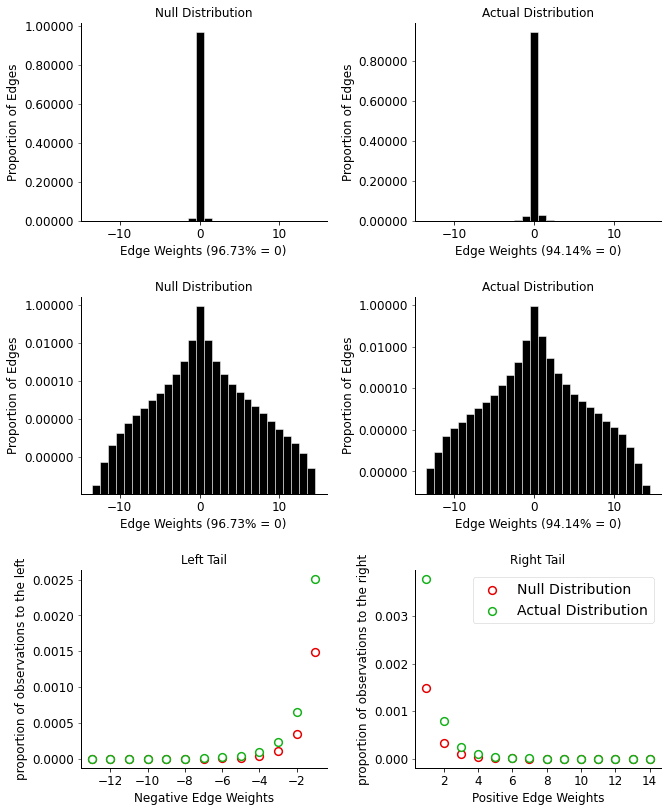

In [68]:
plot_null_v_actual_distributions('ATB_v_LTBI')

### ATB v HC

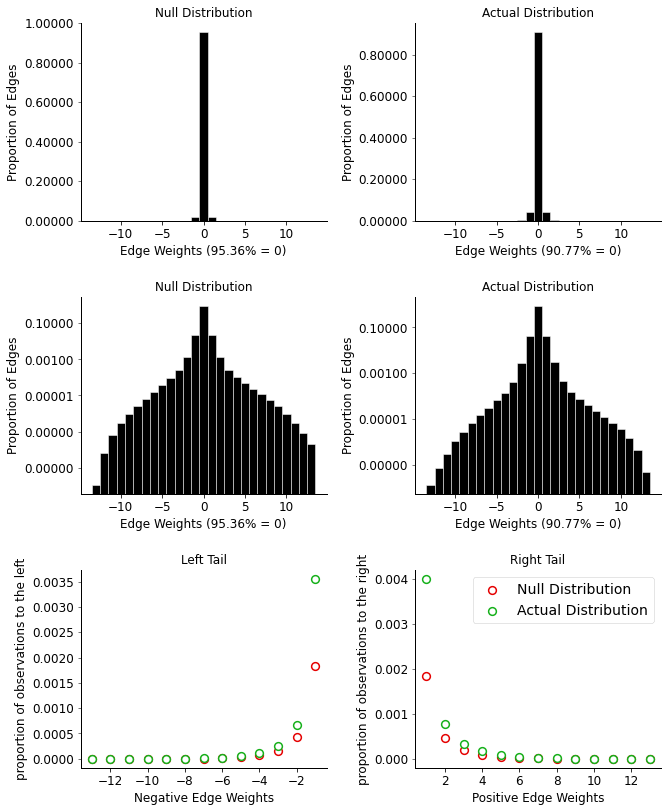

In [82]:
plot_null_v_actual_distributions('ATB_v_HC')

### ATB v OD

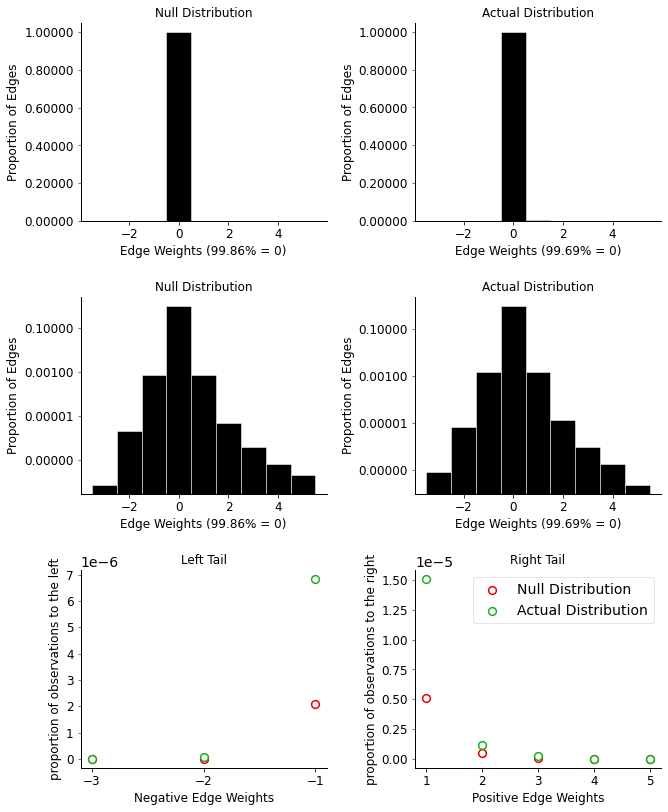

In [83]:
plot_null_v_actual_distributions('ATB_v_OD')

### LTBI v HC

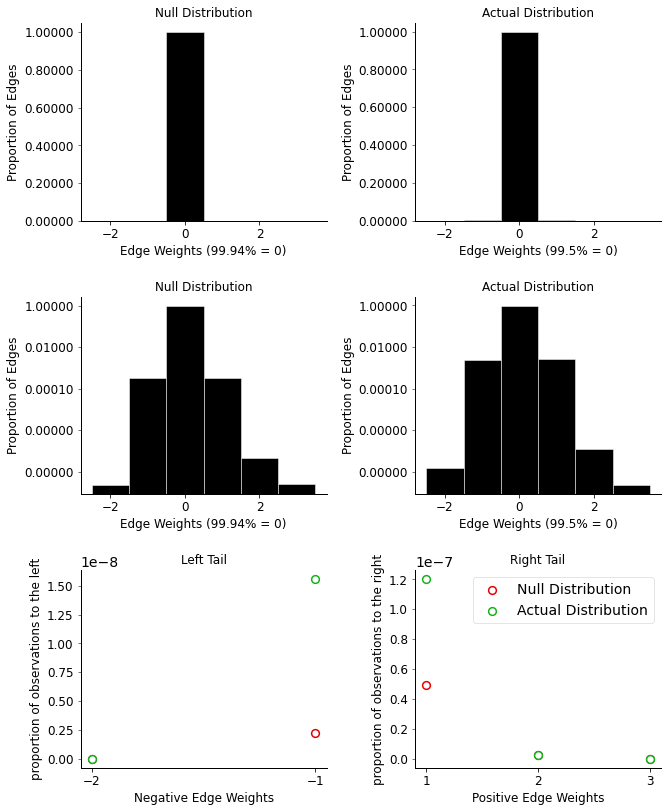

In [77]:
plot_null_v_actual_distributions('LTBI_v_HC')